## Modeling for predicting critical outcome at ED disposition

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [2]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve, get_lstm_data_gen
from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0

In [3]:
random.seed(random_seed)
np.random.seed(random_seed)

In [4]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcomplaint,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,394512,10509415,NaN,39157213,2178-11-07 21:01:00,2178-11-07 21:26:00,45,M,2173,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,50,False,0 days 00:25:00,NaN,NaN,False,False,False,0,0,0,2178-11-09 10:37:00,1 days 13:11:00,True,0,0,0,0,0,0,0.42,NaN,1.55,36.722222,74.0,20.0,100.0,162.0,129.0,9.0,2.0,Abd pain,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,72.0,16.0,100.0,180.0,123.0,0.0,3.0,9.0,140.000000,2,0,5,0,0,1
1,163920,19402485,27265022.0,35695207,2149-04-10 22:36:00,2149-04-11 00:47:05,55,M,2149,NaN,2149-04-11 00:46:00,2149-04-12 15:00:00,NaN,BLACK/AFRICAN AMERICAN,2149-04-10 22:36:00,2149-04-11 03:20:00,Other,2149,55,False,0 days 02:11:05,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,2.18,NaN,NaN,36.777778,90.0,20.0,97.0,131.0,77.0,0.0,2.0,Abd pain,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,68.0,18.0,100.0,128.0,68.0,0.0,2.0,6.0,95.000000,1,4,3,0,0,1
2,235492,12126972,21011915.0,33586273,2110-03-31 10:59:00,2110-03-31 15:33:00,65,F,2110,NaN,2110-03-31 14:50:00,2110-04-02 13:40:00,NaN,WHITE,2110-03-31 10:59:00,2110-03-31 15:33:00,Other,2110,65,False,0 days 04:34:00,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,4.57,NaN,NaN,36.833333,90.0,18.0,94.0,122.0,71.0,0.0,1.0,"Dental pain, Facial swelling",...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.333333,84.0,22.0,93.0,138.0,80.0,4.0,4.0,3.0,88.000000,2,4,5,1,0,1
3,43991,17759885,NaN,31346320,2155-01-03 09:43:00,2155-01-03 09:54:00,63,F,2154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2155,64,False,0 days 00:11:00,NaN,NaN,False,False,False,0,1,1,2155-02-10 12:49:00,38 days 02:55:00,False,0,0,0,0,0,0,0.18,NaN,38.12,36.611111,98.0,14.0,99.0,136.0,71.0,2.0,3.0,Wound eval,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.222222,85.0,14.0,99.0,138.0,78.0,0.0,0.0,4.0,92.666667,2,4,3,1,1,0
4,291495,12197131,26028634.0,34998956,2123-07-30 11:41:00,2123-07-30 23:24:00,60,M,2123,NaN,2123-07-30 17:24:00,2123-08-08 13:02:00,NaN,OTHER,2123-07-30 11:41:00,2123-07-30 23:24:00,Medicaid,2123,60,False,0 days 11:43:00,NaN,NaN,False,True,False,0,0,0,2125-08-30 20:50:00,761 days 21:26:00,False,0,0,0,0,0,0,11.72,NaN,761.89,36.833333,82.0,16.0,100.0,125.0,85.0,3.0,3.0,LEFT NECK SWELLING,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,75.0,17.0,100.0,144.0,80.0,0.0,7.0,8.0,98.333333,2,4,3,0,0,1


### 1. task-specific filter: No specific filtering needed

In [5]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 353150 , testing size = 88287


### 2. Variable Selection

In [6]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_critical"

In [7]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [8]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [9]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [10]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [11]:
print('class ratio')
print('positiave : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positiave : negative = 0.06337811877073911 : 1


### 3.  Modeling script

In [12]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/miniconda3/envs/mimic-ed/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.0208284854888916 seconds
AUC: 0.8590964014479328
AUPRC: 0.36222312499883724
Sensitivity: 0.7746781115879828
Specificity: 0.7832156900470173
Score thresold: 0.057536669867895615
2.5 97.5


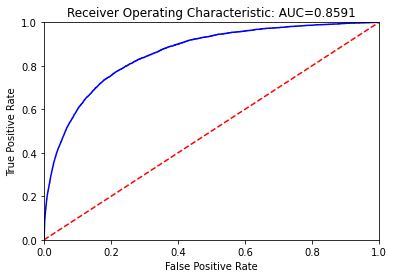

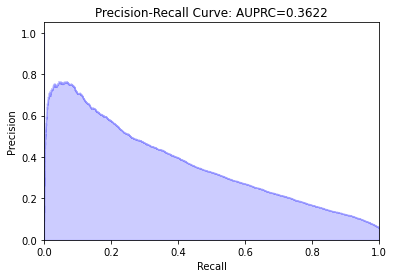

In [13]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task4_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 46.553555488586426 seconds
AUC: 0.9320674913817757
AUPRC: 0.5650590709549483
Sensitivity: 0.8560280920795942
Specificity: 0.8500378783323914
Score thresold: 0.1
2.5 97.5


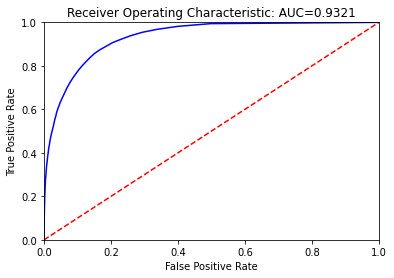

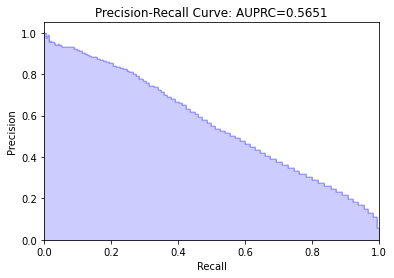

[0.06270016 0.01075148 0.00476144 0.00770979 0.01368407 0.00471633
 0.00754077 0.01253559 0.00292989 0.00541535 0.00930106 0.03145984
 0.08376126 0.00472625 0.00434913 0.0032185  0.00099364 0.00141495
 0.00174557 0.00187304 0.00370001 0.00224587 0.00211987 0.00358143
 0.00451441 0.00350698 0.00366389 0.00207622 0.00493189 0.00183147
 0.00197835 0.00346793 0.00508525 0.00336771 0.00193376 0.00384441
 0.00402562 0.00210308 0.00283508 0.00083189 0.00508381 0.00344465
 0.0032592  0.00391899 0.00647622 0.00398362 0.00381853 0.0013962
 0.00406721 0.00382491 0.00333954 0.00518579 0.00166619 0.00308509
 0.00331094 0.00255106 0.00172232 0.00467436 0.0552318  0.08401768
 0.07733835 0.03442679 0.06905549 0.05763707 0.12128061 0.05283871
 0.04613166]


In [14]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 68.46377801895142 seconds
AUC: 0.9339750714504907
AUPRC: 0.5571594924217134
Sensitivity: 0.8573936792820913
Specificity: 0.849989778862688
Score thresold: 0.07700290016031408
2.5 97.5


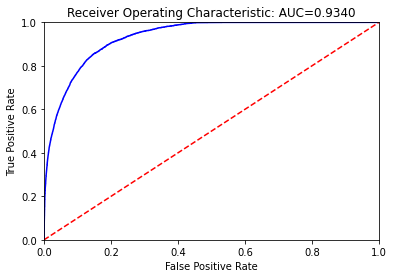

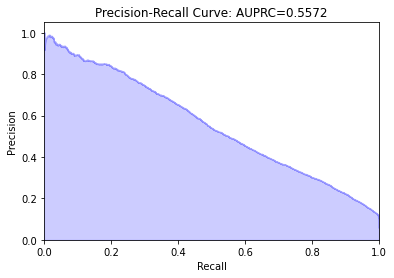

In [15]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [16]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [17]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_disposition_mlp')

2022-10-03 21:26:26.479431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 21:26:27.382268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-10-03 21:26:27.382829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22304 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/20
  40/1766 [..............................] - ETA: 6s - loss: 0.5243 - accuracy: 0.9051 - auc: 0.6612 - auprc: 0.1098 - true_positives: 66.0000 - true_negatives: 7175.0000 - precision: 0.1542 - recall: 0.1425

2022-10-03 21:26:29.315995: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1766/1766 [==============================] - 10s 5ms/step - loss: 0.1685 - accuracy: 0.9424 - auc: 0.8832 - auprc: 0.3796 - true_positives: 5027.0000 - true_negatives: 327767.0000 - precision: 0.5370 - recall: 0.2388
Epoch 2/20
1766/1766 [==============================] - 8s 5ms/step - loss: 0.1449 - accuracy: 0.9466 - auc: 0.9107 - auprc: 0.4689 - true_positives: 5899.0000 - true_negatives: 328406.0000 - precision: 0.6148 - recall: 0.2803
Epoch 3/20
1766/1766 [==============================] - 8s 5ms/step - loss: 0.1406 - accuracy: 0.9477 - auc: 0.9166 - auprc: 0.4867 - true_positives: 5992.0000 - true_negatives: 328688.0000 - precision: 0.6370 - recall: 0.2847
Epoch 4/20
1766/1766 [==============================] - 8s 5ms/step - loss: 0.1366 - accuracy: 0.9487 - auc: 0.9218 - auprc: 0.5073 - true_positives: 6144.0000 - true_negatives: 328903.0000 - precision: 0.6576 - recall: 0.2919
Epoch 5/20
1766/1766 [==============================] - 8s 5ms/step - loss: 0.1336 - accuracy: 0.9500 

MLP:
2759/2759 [==============================] - 4s 1ms/step
AUC: 0.9370735215736327
AUPRC: 0.5593274682040338
Sensitivity: 0.8802184939523995
Specificity: 0.8373997426678371
Score thresold: 0.068911895
2.5 97.5


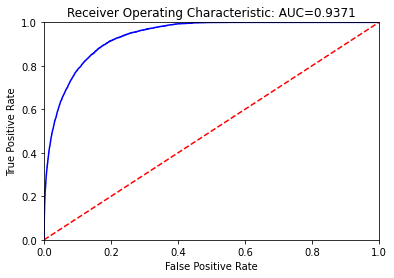

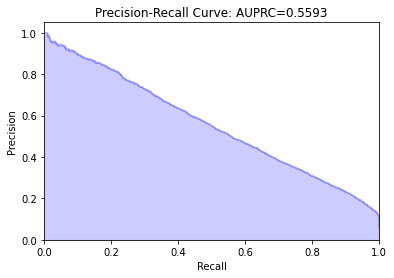

In [18]:
print("MLP:")
mlp = load_model('critical_disposition_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [19]:
# Loading data for LSTM
resample_freq = '1H' #'30T'
df_vitalsign = pd.read_csv(os.path.join(path, 'ed_vitalsign_' + resample_freq + '_resampled.csv'))

In [20]:
train_data_gen, test_data_gen = get_lstm_data_gen(df_train, df_test, df_vitalsign, variable, outcome)

In [21]:
class LSTM_MLP(tf.keras.Model):
    def __init__(self):
        super(LSTM_MLP, self).__init__()
        self.dense_1 = Dense(96, activation='relu')
        self.lstm = LSTM(32)
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x1, x2 = x
        x = self.dense_1(x1)
        lstm_output = self.lstm(x2)
        x = concatenate([x, lstm_output])
        x = self.dense_2(x)
        return self.classifier(x)

In [22]:
# skip this cell if not retraining
lstm = LSTM_MLP()
lstm.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

start = time.time()
lstm.fit(train_data_gen, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
lstm.save('critial_disposition_lstm')

Epoch 1/20


2022-10-03 21:29:26.104276: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


1766/1766 [==============================] - 1069s 604ms/step - loss: 0.3698 - accuracy: 0.9399 - auc: 0.8710 - auprc: 0.3284 - true_positives: 5218.0000 - true_negatives: 326720.0000 - precision: 0.4923 - recall: 0.2479
Epoch 2/20
1766/1766 [==============================] - 1075s 609ms/step - loss: 0.1431 - accuracy: 0.9482 - auc: 0.9140 - auprc: 0.4982 - true_positives: 6865.0000 - true_negatives: 327976.0000 - precision: 0.6246 - recall: 0.3262
Epoch 3/20
1766/1766 [==============================] - 1089s 616ms/step - loss: 0.1371 - accuracy: 0.9499 - auc: 0.9205 - auprc: 0.5216 - true_positives: 7126.0000 - true_negatives: 328332.0000 - precision: 0.6540 - recall: 0.3386
Epoch 4/20
1766/1766 [==============================] - 1092s 618ms/step - loss: 0.1354 - accuracy: 0.9502 - auc: 0.9226 - auprc: 0.5251 - true_positives: 6990.0000 - true_negatives: 328569.0000 - precision: 0.6643 - recall: 0.3321
Epoch 5/20
1766/1766 [==============================] - 1093s 619ms/step - loss: 0.

INFO:tensorflow:Assets written to: critial_disposition_lstm/assets


INFO:tensorflow:Assets written to: critial_disposition_lstm/assets


LSTM:
442/442 [==============================] - 272s 615ms/step
AUC: 0.9446646202778871
AUPRC: 0.5972359465555187
Sensitivity: 0.8675380413577839
Specificity: 0.8660189271413283
Score thresold: 0.06957782
2.5 97.5


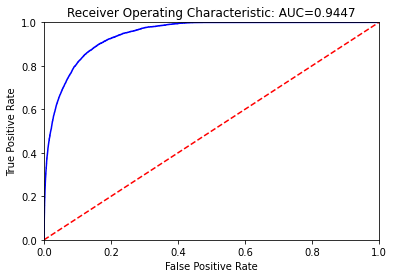

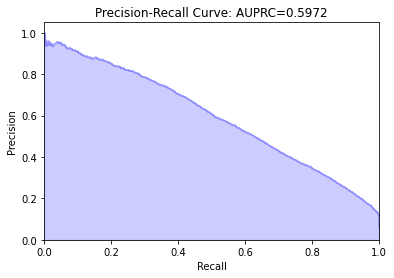

In [23]:
print("LSTM:")
lstm = load_model('critial_disposition_lstm')
probs = lstm.predict(test_data_gen)
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LSTM"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [24]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.8039655054643638
AUPRC: 0.1942196456343015
Sensitivity: 0.870074131876707
Specificity: 0.6401197676795614
Score thresold: -2.0
2.5 97.5


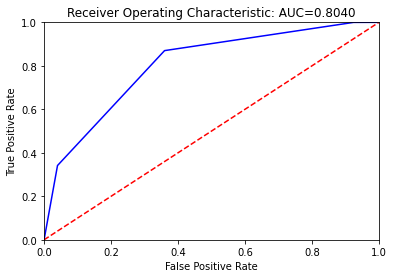

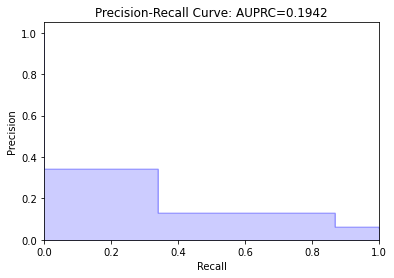

In [25]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

score_NEWS
AUC: 0.6341903573953401
AUPRC: 0.14157240789712475
Sensitivity: 0.46390948107686303
Specificity: 0.7954810548213707
Score thresold: 2
2.5 97.5


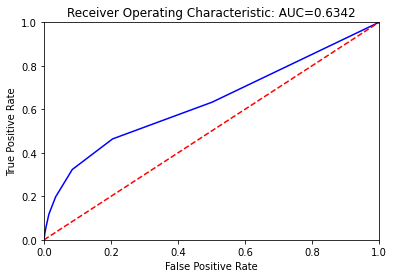

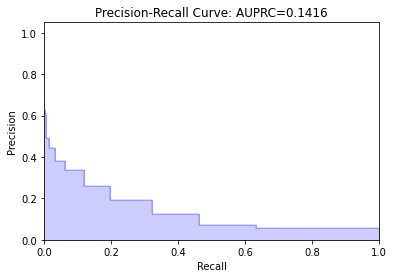

In [26]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6165137178284772
AUPRC: 0.12807667183072463
Sensitivity: 0.4104564962934062
Specificity: 0.8225490313969288
Score thresold: 2
2.5 97.5


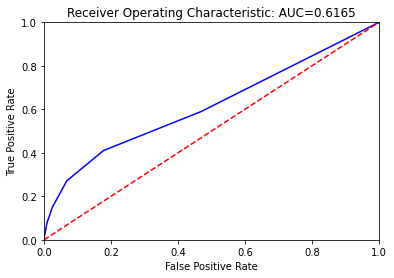

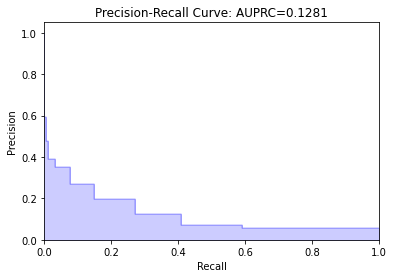

In [27]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6858237001110102
AUPRC: 0.10555264874976322
Sensitivity: 0.6808427623878268
Specificity: 0.6155649883960029
Score thresold: 5
2.5 97.5


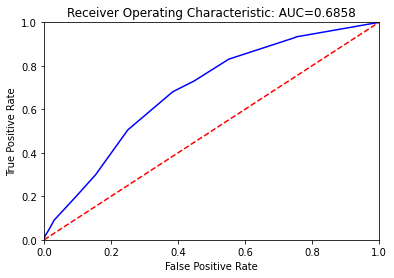

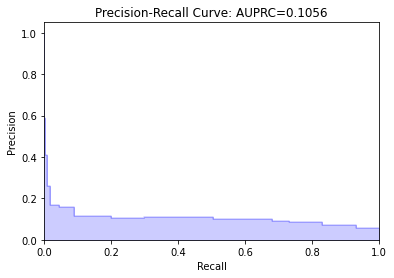

In [28]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6136127819001566
AUPRC: 0.10350411545674533
Sensitivity: 0.43055013655872026
Specificity: 0.7698801120717644
Score thresold: 2
2.5 97.5


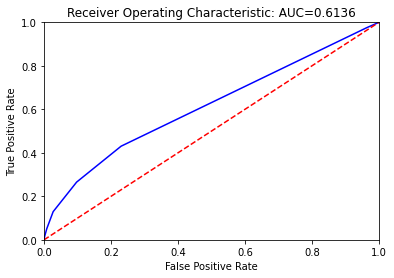

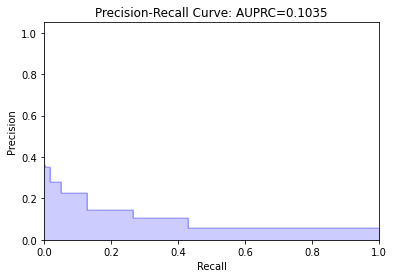

In [29]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.7074561210922072
AUPRC: 0.14183887641580045
Sensitivity: 0.5901287553648069
Specificity: 0.7307271437332403
Score thresold: 6
2.5 97.5


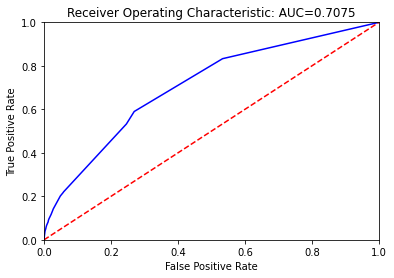

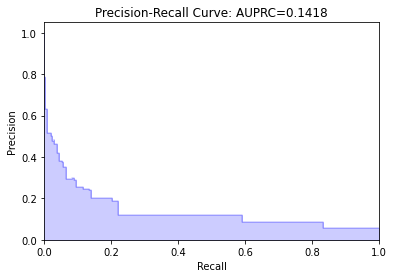

In [30]:
get_score_performance("score_CART", random_seed=random_seed)

### 4. Performance output

In [31]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                              'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                              'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
                                              'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_disposition.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task4.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.058,0.859 (0.855-0.865),0.362 (0.347-0.374),0.775 (0.762-0.791),0.783 (0.767-0.793),3.021
1,RF,0.100,0.932 (0.93-0.935),0.565 (0.554-0.583),0.856 (0.851-0.88),0.85 (0.836-0.852),46.554
2,GB,0.077,0.934 (0.932-0.936),0.557 (0.543-0.571),0.857 (0.847-0.861),0.85 (0.846-0.857),68.464
3,MLP,0.069,0.937 (0.935-0.939),0.559 (0.544-0.572),0.88 (0.865-0.884),0.837 (0.837-0.848),167.822
4,LSTM,0.070,0.945 (0.943-0.947),0.597 (0.583-0.608),0.868 (0.867-0.888),0.866 (0.85-0.868),21781.640
5,ESI,-2.000,0.804 (0.801-0.809),0.194 (0.187-0.205),0.87 (0.863-0.875),0.64 (0.637-0.643),0.000
6,score_NEWS,2.000,0.634 (0.627-0.641),0.142 (0.132-0.145),0.464 (0.453-0.472),0.795 (0.793-0.798),0.000
7,score_NEWS2,2.000,0.617 (0.608-0.624),0.128 (0.122-0.132),0.41 (0.398-0.585),0.823 (0.532-0.824),0.000
8,score_REMS,5.000,0.686 (0.679-0.691),0.106 (0.102-0.111),0.681 (0.668-0.687),0.616 (0.613-0.619),0.000
9,score_MEWS,2.000,0.614 (0.607-0.618),0.104 (0.1-0.109),0.431 (0.418-0.439),0.77 (0.768-0.772),0.000


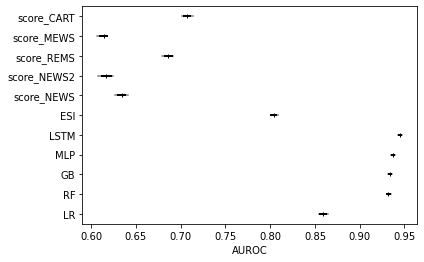

In [32]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

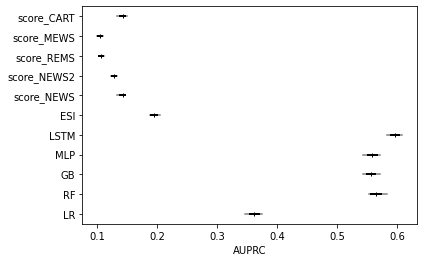

In [33]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [34]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
64,ed_los,0.121281
59,ed_heartrate_last,0.084018
12,triage_acuity,0.083761
60,ed_resprate_last,0.077338
62,ed_sbp_last,0.069055
0,age,0.062700
63,ed_dbp_last,0.057637
58,ed_temperature_last,0.055232
65,n_med,0.052839
66,n_medrecon,0.046132
